## Modelling
---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
df = pd.read_parquet("data/transactions.parquet")


In [20]:
df[
    [
        "Shop",
        "ProductCode",
        "CustomerID",
        "SaleDocumentNumber",
        "BrandName",
        "ModelGroup",
        "ProductGroup",
    ]
] = df[
    [
        "Shop",
        "ProductCode",
        "CustomerID",
        "SaleDocumentNumber",
        "BrandName",
        "ModelGroup",
        "ProductGroup",
    ]
].astype("string")
df["Order_Date_FK"] = pd.to_datetime(df["Order_Date_FK"], format="%Y%m%d")
df["Month"] = df["Order_Date_FK"].dt.month
df["Day"] = df["Order_Date_FK"].dt.day
df["Weekday"] = df["Order_Date_FK"].dt.weekday
df.drop(columns=["Order_Date_FK"], inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759889 entries, 0 to 1759888
Data columns (total 14 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Shop                       string 
 1   ProductCode                string 
 2   OriginalSaleAmountInclVAT  float64
 3   CustomerID                 string 
 4   SaleDocumentNumber         string 
 5   Returned                   int64  
 6   RevenueInclVAT             float64
 7   CostPriceExclVAT           float64
 8   BrandName                  string 
 9   ModelGroup                 string 
 10  ProductGroup               string 
 11  Month                      int32  
 12  Day                        int32  
 13  Weekday                    int32  
dtypes: float64(3), int32(3), int64(1), string(7)
memory usage: 167.8 MB


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.model_selection import train_test_split


In [22]:
# Split the data into features (X) and target (y)
X = df.drop("Returned", axis=1)
y = df["Returned"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [23]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


RandomForestClassifier()

In [24]:
y_pred = rf.predict(X_test)

# Calculate the accuracy of the model.

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Display the classification report and confusion matrix.

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 97.88%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    338450
           1       0.89      0.51      0.65     13528

    accuracy                           0.98    351978
   macro avg       0.94      0.75      0.82    351978
weighted avg       0.98      0.98      0.98    351978

Confusion Matrix:
[[337640    810]
 [  6637   6891]]


In [ ]:
param_grid = {
    "n_estimators": [200, 500],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"],
}


In [43]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

y_pred_proba = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print("Best Threshold=%f" % (best_thresh))


Best Threshold=0.062500


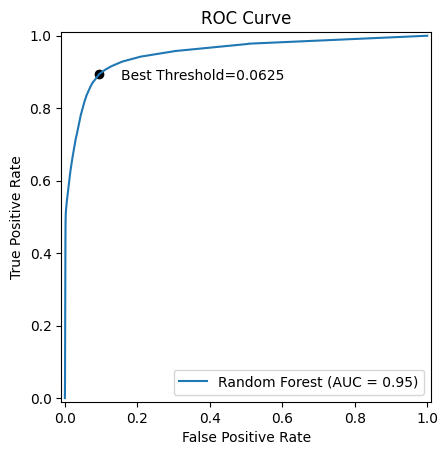

In [57]:
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Random Forest"
)
display.plot()
plt.scatter(fpr[ix], tpr[ix], marker="o", color="black")
plt.text(fpr[ix] + 0.06, tpr[ix] - 0.015, f"Best Threshold={best_thresh}")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


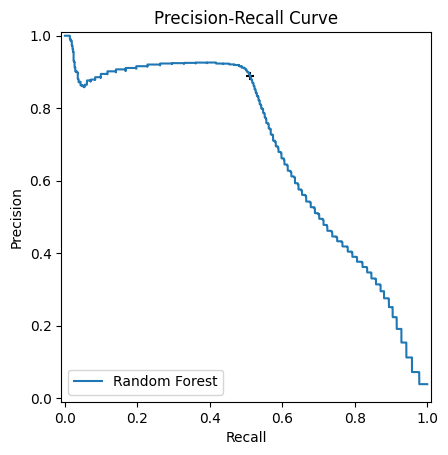

In [62]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_display = PrecisionRecallDisplay(
    precision=prec, recall=recall, estimator_name="Random Forest"
)
pr_display.plot()
plt.scatter(0.51, 0.89, marker="+", color="black")
# plt.axvline(x=0.51, color="green", linestyle="--")
# plt.axhline(y=0.89, color="red", linestyle="--")
plt.title("Precision-Recall Curve")
plt.show()


In [68]:
random_grid = {
    "bootstrap": [True, False],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [130, 180, 230],
}
"""
parameter_grid = {
    "n_estimators": [1, 2, 3, 4, 5],
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [1, 2, 3, 4, 5, 6, 7, 8],
}
"""


'\nparameter_grid = {\n    "n_estimators": [1, 2, 3, 4, 5],\n    "max_depth": [2, 4, 6, 8, 10],\n    "min_samples_leaf": [1, 2, 4],\n    "max_features": [1, 2, 3, 4, 5, 6, 7, 8],\n}\n'

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC


In [ ]:
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
CV_rf.fit(X_train, y_train)


In [71]:
CV_rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
# Fit the random search model
rf_random.fit(X_1, Y)


NameError: name 'X_1' is not defined